# Predicting Traffic Volume on the I-94 in Minnesota, USA

Written by: Marshall Mykietyshyn

Data hosted on [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

The purpose of this notebook is to predict the traffic flow at a particular point of an interstate highway. The data was recorded hourly on highway I-94 between Minneapolis and St. Paul, Minnesota over a six year period. It contains both numerical and categorical features, with a target variable counting the number of cars passing a point each hour. Descriptions and ranges of the features are given below.

1. holiday (categorical) - national and regional holidays: either None or name of holiday
2. temp (numerical continuous) - average temperature over the course of the hour (Kelvin): 0.00 to 310.07
3. rain_1h (numerical continuous) - rain that fell during the hour (mm): 0.0 to 9831.3
4. snow_1h (numerical continuous) - amount of snow accumulated during the hour (mm): 0.0 to 0.51
5. clouds_all (numerical discrete) - percentage of cloud cover (%): 0 to 100
6. weather_main (categorical) - short description of weather for the hour: eg. 'sunny' or 'rainy'
7. weather_description (categorical) - more detailed description of the weather: 7.9 to 860.6
8. date_time (date/time) - the date and time of day the data was measured: 0.0 to 56.10
9. traffic_volume (numerical discrete) - number of cars passing point of interest (target variable): 0 to 7280


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt
from time import time
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, ShuffleSplit, TimeSeriesSplit
from my_regression import whitening_transform, BinaryEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Turn off chained assignment warnings
pd.options.mode.chained_assignment = None

# Display long entries in data frames
pd.options.display.max_colwidth = 250


In [2]:
def CyclicalEncoder(data, col_ls):
    """ Encodes cyclical categorical data as continuous sine and cosine values.
    
    Categorical data needs to be encoded such that it is usable by ML algorithms.
    However, encoding data that has a meaningful cyclical order (often temporal
    data) using normal encoding methods causes it to lose the hierarchichal
    information contained within it. Therefore, encoding the data as a series of
    sine and cosine values allows one to maintain this information, for use in
    machine learning models.
    
    This method adds two columns to the data, one for each of the sine and cosine
    values. The columns are concatenated and returned.
    
    This function requires that the categorical data has already been converted
    to be represented by a range of ints, and scaled to the range [0, 1].
    
    Paramters
        data: DataFrame = all data
        col_ls: list = list of column names to be encoded
        
    Returns
        cyc_data: DataFrame = cyclical data encoded columns
        n_enc_col: int = total number of encoded columns in output
    """
    
    n_enc_col = 0
    for i, col in enumerate(col_ls):
        # Each cyclical column produces two encoded columns
        n_enc_col += 2
        
        # Calculate the encoding for each cyclical period
        cyc_enc = np.zeros((len(data), 2))
        zero_inds = list(data.loc[data[col] == 0].index + 1) + [None]
        last_ind = 0
        for this_ind in zero_inds:
            period = data[col].iloc[last_ind:this_ind].values
            norm_period = period / (period.max() + 1) * 2 * np.pi
            cyc_enc[last_ind:this_ind, 0] = np.cos(norm_period)
            cyc_enc[last_ind:this_ind, 1] = np.sin(norm_period)
            last_ind = this_ind
        
        # Assign new column names
        col_names = [col + '_cos', col + '_sin']
        
        # Concatenate the encoded columns
        if i == 0:
            cyc_data = pd.DataFrame(cyc_enc, columns=col_names)
        else:
            cyc_data = pd.concat([pd.DataFrame(cyc_enc, columns=col_names), cyc_data], axis=1)
        
    return cyc_data, n_enc_col


## Data Preprocessing

- Standard checks for NaNs and missing values
- Had to take care of some suspicious values in "rain_1h" and "snow_1h". Dropped "snow_1h" feature due to the high likelihood that there are errors in recording these values (only days with recorded snow are a span of about 2 weeks). 
- Perhaps drop the rain category as well, since it has so many zeros
- Detailed weather descriptions do not seem to provide more information than could be gleaned from the simple description plus the weather data. Therefore, dropped the feature.
- Holidays only marked at midnight hour (needed to expand to fill all hours of day)
- Added "hour" and "day of year" categorical features, derived from date_time. 
- Only contains data for the first half of 2014 and last half of 2015 (about a year is missing)
- Encoded all categorical features (either cyclical or binary)
- Since none of the variables are particularly Gaussian, normalize the data, rather than whitening
- Target is multimodal. Tree regressors (random forest and XGBoost are agnostic to this)


In [3]:
# Load an look at overview of data
data = pd.read_csv('data/Metro_Interstate_Traffic_Volume.csv')

# Drop the longer weather descriptions
data.drop(columns=['weather_description'], inplace=True)

# Convert the date-time column to the proper format
data.date_time = pd.to_datetime(data.date_time)

# Display the data and its summary statistics
display(data.head(n=5))
display(data.describe())


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,2012-10-02 13:00:00,4918


,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [4]:
# Check for NaNs
data.isna().sum()


holiday           0
temp              0
rain_1h           0
snow_1h           0
clouds_all        0
weather_main      0
date_time         0
traffic_volume    0
dtype: int64

In [5]:
# Check for non-numerical values in numerical columns
data.applymap(np.isreal).sum()


holiday               0
temp              48204
rain_1h           48204
snow_1h           48204
clouds_all        48204
weather_main          0
date_time         48204
traffic_volume    48204
dtype: int64

## Suspicious values

The temperatures are in Kelvin, where 0K corresponds to absolute zero = -273.15C. Therefore, the min temperature of 0K is highly suspicious. After looking at the data, it was found that no reasonable temperature was recorded for two short intervals. Since the intervals are relatively short (4 and 6 hours respectively) and the temperature before and after the intervals are roughly similar, the temperatures can be imputed using simple linear interpolation. This is done to maintain the continuity of the temporal data.

Additionally, the maximum rain and snow values seem off. Nine meters of rain is a ridiculous amount to fall in one hour. Luckily, this seems to simply be an anomaly, as there is only one entry with greater than 100mm of rainfall. All weather data for Minneapolis-St. Paul on this date indicates trace rainfall (for example [here](https://www.dnr.state.mn.us/climate/historical/daily-data.html?sid=mspthr&sname=Minneapolis/St%20Paul%20Threaded%20Record&sdate=2010-01-01&edate=por) and [here](https://www.weather.gov/media/mpx/Climate/MSP/jul2016.pdf)), so this entry will be divided by 10000, to make the rainfall less than 1mm. 

All of the nonzero snowfall values occur in the date range 23.12.2015-08.01.2016, and there are only 63 entries where any snowfall is recorded Furthermore, many of these seem to be duplicate entries, where there are multiple entries for the same hour. This is obviously wrong, and it can be shown by a quick check of the [weather data](https://www.dnr.state.mn.us/climate/historical/daily-data.html?sid=mspthr&sname=Minneapolis/St%20Paul%20Threaded%20Record&sdate=2010-01-01&edate=por), where one can find entries as great as 16.3" (41.4mm) for a single day. Therefore, it does not seem that snowfall is a reliable feature, and will be dropped from the data.

Lastly, as found during this analysis, there are duplicate entries for individual hours. These seem to be associated with multiple weather_main categories for a single hour, likely meaning the weather in that hour could not be described by a single category.  If left, these would bias the data. Therefore, these must be handled by selecting a single weather description for each hour. It does not seem that the order of descriptions is systematic. Therefore, using pandas built-in drop duplicates function, where the first of the duplicated entries is kept, should be a sufficient way to handle this.


In [6]:
# Check suspicious min temp rows (-40C = 233K)
display(data.loc[data.temp < 233])


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
11898,None,0.0,0.0,0.0,0,Clear,2014-01-31 03:00:00,361
11899,None,0.0,0.0,0.0,0,Clear,2014-01-31 04:00:00,734
11900,None,0.0,0.0,0.0,0,Clear,2014-01-31 05:00:00,2557
11901,None,0.0,0.0,0.0,0,Clear,2014-01-31 06:00:00,5150
11946,None,0.0,0.0,0.0,0,Clear,2014-02-02 03:00:00,291
11947,None,0.0,0.0,0.0,0,Clear,2014-02-02 04:00:00,284
11948,None,0.0,0.0,0.0,0,Clear,2014-02-02 05:00:00,434
11949,None,0.0,0.0,0.0,0,Clear,2014-02-02 06:00:00,739
11950,None,0.0,0.0,0.0,0,Clear,2014-02-02 07:00:00,962
11951,None,0.0,0.0,0.0,0,Clear,2014-02-02 08:00:00,1670


In [7]:
# Split the data into continuous blocks of 0 Kelvin data points
too_low_temps = data.loc[data.temp < 233].index.values
# jumps = list(np.where(np.diff(too_low_temps) > 1)[0] + 1) + [None]
jumps = np.where(np.diff(too_low_temps) > 1)[0] + 1
ind_pairs = []
missing_ranges = []
last_ind = 0
for ind in jumps:
    missing_ranges.append(too_low_temps[last_ind:ind])
    last_ind = ind
missing_ranges.append(too_low_temps[last_ind:])

# # Display the data points before and after the missing temperatures
# for temp_range in missing_ranges:
#     inds = np.arange(temp_range[0] - 1, temp_range[-1] + 2)
#     display(data.iloc[inds, :])
    

In [8]:
# Interpolate through the block
for temp_inds in missing_ranges:
    t1 = data.temp.iloc[temp_inds[0] - 1]
    t2 = data.temp.iloc[temp_inds[-1] + 1]
    new_temps = np.linspace(t1, t2, len(temp_inds) + 2)[1:-1]
    data.temp.iloc[temp_inds.tolist()] = new_temps

# # Display the data points before and after the missing temperatures
# for temp_range in missing_ranges:
#     inds = np.arange(temp_range[0] - 1, temp_range[-1] + 2)
#     display(data.iloc[inds, :])


In [9]:
# Check high rain volume rows
display(data.loc[data.rain_1h > 100])

# Divide the value such that it is less than 1mm
rain_ind = data.loc[data.rain_1h > 100].index.values
data.rain_1h.iloc[rain_ind] /= 1e4
display(data.iloc[rain_ind, :])


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
24872,None,302.11,9831.3,0.0,75,Rain,2016-07-11 17:00:00,5535


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
24872,None,302.11,0.98313,0.0,75,Rain,2016-07-11 17:00:00,5535


In [10]:
# Check low snow fall depths
display(data.loc[data.snow_1h > 0])
data.drop(columns=['snow_1h'], inplace=True)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
20158,None,274.33,0.98,0.51,90,Rain,2015-12-23 12:00:00,5167
20159,None,274.33,0.98,0.51,90,Snow,2015-12-23 12:00:00,5167
20160,None,274.33,0.98,0.51,90,Mist,2015-12-23 12:00:00,5167
20161,None,274.33,0.98,0.51,90,Fog,2015-12-23 12:00:00,5167
20162,None,273.74,0.00,0.32,90,Snow,2015-12-23 14:00:00,5182
...,...,...,...,...,...,...,...,...
20494,None,273.22,0.00,0.08,90,Mist,2016-01-08 03:00:00,401
20507,None,273.80,0.00,0.25,90,Snow,2016-01-08 13:00:00,4933
20508,None,273.80,0.00,0.25,90,Mist,2016-01-08 13:00:00,4933
20509,None,273.67,0.00,0.13,90,Snow,2016-01-08 15:00:00,5548


In [11]:
# Drop the entries where there are multiple rows for the same hour
display(len(data[data.date_time.duplicated()]))
clean_data = data.drop_duplicates(subset='date_time')
clean_data = clean_data.reset_index(drop=True)
display(len(clean_data))


7629

40575

In [12]:
# Look at the stats again
display(clean_data.describe())


,temp,rain_1h,clouds_all,traffic_volume
count,40575.000000,40575.000000,40575.000000,40575.000000
mean,281.379775,0.076357,44.199162,3290.650474
std,13.097795,0.769639,38.683447,1984.772909
min,243.390000,0.000000,0.000000,0.000000
25%,271.840000,0.000000,1.000000,1248.500000
50%,282.860000,0.000000,40.000000,3427.000000
75%,292.280000,0.000000,90.000000,4952.000000
max,310.070000,55.630000,100.000000,7280.000000


In [13]:
# Generate new columns for hour and day of the year
clean_data['hour'] = clean_data.date_time.dt.hour
# clean_data['day_of_year'] = clean_data.date_time.dt.dayofyear - 1 + (data.hour / 24)
clean_data['day_of_week'] = clean_data.date_time.dt.dayofweek
clean_data['day_of_year'] = clean_data.date_time.dt.dayofyear - 1
clean_data['year'] = clean_data.date_time.dt.year

# display(clean_data.loc[clean_data.year == 2014])
# display(clean_data.loc[clean_data.year == 2015])
# # display(clean_data.head(n=10))
# display(clean_data.iloc[2102:2105, :])
# display(clean_data.iloc[9396:9399, :])
# display(clean_data.iloc[13897:13900, :])
# display(clean_data.iloc[17490:17493, :])
# display(clean_data.iloc[25328:25331, :])
# display(clean_data.iloc[34041:34044, :])
# display(clean_data.tail(n=10))
# [2104, 9398, 13898, 17492, 25330, 34043]


In [14]:
# Holidays are only marked at midnight, fill other hours of the day
display(len(clean_data.loc[clean_data.holiday != 'None']))
# display(data.loc[data.holiday != 'None'])
day_h = 24
holi_data = clean_data.copy()
holiday_inds = holi_data.loc[holi_data.holiday != 'None'].index
for ind in holiday_inds:
    this_holiday = holi_data.holiday.iloc[ind]
    holi_data.holiday.iloc[ind:ind + day_h] = this_holiday
display(len(holi_data.loc[holi_data.holiday != 'None']))

# Change holiday to a binary value
holi_data.loc[holi_data.holiday != 'None', 'holiday'] = 1
holi_data.loc[holi_data.holiday == 'None', 'holiday'] = 0
holi_data.holiday = pd.to_numeric(holi_data.holiday)
# display(holi_data.head(n=10))


53

1272

In [15]:
# Add a binary weekday category
# df['Price'] = [1500 if x =='Music' else 800 for x in df['Event']]
holi_data['weekday'] = [1 if x < 5 else 0 for x in holi_data.day_of_week]
holi_cols = holi_data.columns.tolist()
holi_cols = holi_cols[-1:] + holi_cols[:-1]
holi_data = holi_data[holi_cols]
display(holi_data.head(n=5))


,weekday,holiday,temp,rain_1h,clouds_all,weather_main,date_time,traffic_volume,hour,day_of_week,day_of_year,year
0,1,0,288.28,0.0,40,Clouds,2012-10-02 09:00:00,5545,9,1,275,2012
1,1,0,289.36,0.0,75,Clouds,2012-10-02 10:00:00,4516,10,1,275,2012
2,1,0,289.58,0.0,90,Clouds,2012-10-02 11:00:00,4767,11,1,275,2012
3,1,0,290.13,0.0,90,Clouds,2012-10-02 12:00:00,5026,12,1,275,2012
4,1,0,291.14,0.0,75,Clouds,2012-10-02 13:00:00,4918,13,1,275,2012


In [16]:
# Encode the categorical 'weather_main' feature using binary encoding
cat_cols = ['weather_main']
cat_data, n_cat_col = BinaryEncoder(clean_data, cat_cols)
# display(data.head(n=10))


In [17]:
# Encode the hour and day features using cyclical encoding
hr_cols = ['hour']
hr_data, n_cyc_col = CyclicalEncoder(clean_data, hr_cols)

# Must encode year manually due to missing data
day_enc = np.zeros((len(clean_data), 2))
year_inds = list(np.where(np.diff(clean_data.year) > 0)[0] + 1) + [None]
p_max = [366, 365, 365, 365, 366, 365, 365]
# print(year_inds)
last_ind = 0
for i, this_ind in enumerate(year_inds):
    # print(data.year.iloc[last_ind])
    period = clean_data.day_of_year.iloc[last_ind:this_ind].values
    norm_period = period / p_max[i] * 2 * np.pi
    day_enc[last_ind:this_ind, 0] = np.cos(norm_period)
    day_enc[last_ind:this_ind, 1] = np.sin(norm_period)
    last_ind = this_ind

# Assign new column names
col_names = ['day_of_year_cos', 'day_of_year_sin']
day_data = pd.DataFrame(day_enc, columns=col_names)
n_cyc_col += 2
    
# Concatenate the encoded columns
# data = pd.concat([day_data, cyc_data, data], axis=1)
n_enc_col = n_cat_col + n_cyc_col + 2
# display(data.head(n=10))


In [18]:
# Concatenate the data and drop all the columns that are no longer required
enc_data = pd.concat([day_data, hr_data, cat_data, holi_data], axis=1)
pp_data = enc_data.drop(columns=cat_cols + hr_cols + ['date_time', 'day_of_week', 'day_of_year', 'year'])
# pp_data = enc_data.drop(columns=cat_cols + hr_cols + ['date_time', 'day_of_week', 'day_of_year', 'year', 'rain_1h'])


In [19]:
# Scale the skewed rain feature using a log transform
pp_data['rain_1h'] = np.log(pp_data['rain_1h'] + 1)


In [20]:
# Display the pre-processed data
display(pp_data.head(n=5))
# display(data.head(n=5))
# print(n_enc_col)
# display(pp_data.dtypes)


,day_of_year_cos,day_of_year_sin,hour_cos,hour_sin,weather_main_0,weather_main_1,weather_main_2,weather_main_3,weekday,holiday,temp,rain_1h,clouds_all,traffic_volume
0,0.008583,-0.999963,-0.707107,7.071068e-01,0,0,0,1,1,0,288.28,0.0,40,5545
1,0.008583,-0.999963,-0.866025,5.000000e-01,0,0,0,1,1,0,289.36,0.0,75,4516
2,0.008583,-0.999963,-0.965926,2.588190e-01,0,0,0,1,1,0,289.58,0.0,90,4767
3,0.008583,-0.999963,-1.000000,1.224647e-16,0,0,0,1,1,0,290.13,0.0,90,5026
4,0.008583,-0.999963,-0.965926,-2.588190e-01,0,0,0,1,1,0,291.14,0.0,75,4918


## Data Visualization and EDA

Characteristics
- No spatial data
- There is temporal data (5 years, not fully continuous)

Ideas
- Look at flow distribution as a function of hour of day
- Look at flow as a function of weather

Takeaways
- People drive mostly during the day, as would be expected. The peak time is rush hour. Also expected
- It doesn't really matter what the weather is, people drive at the same rate no matter the weather (with the exception of squalls, although this could just be a small sample size issue)
- Night/day split explains much of the bimodality in the target variable. Therefore, can train two independent models for night and day separately to improve performance.


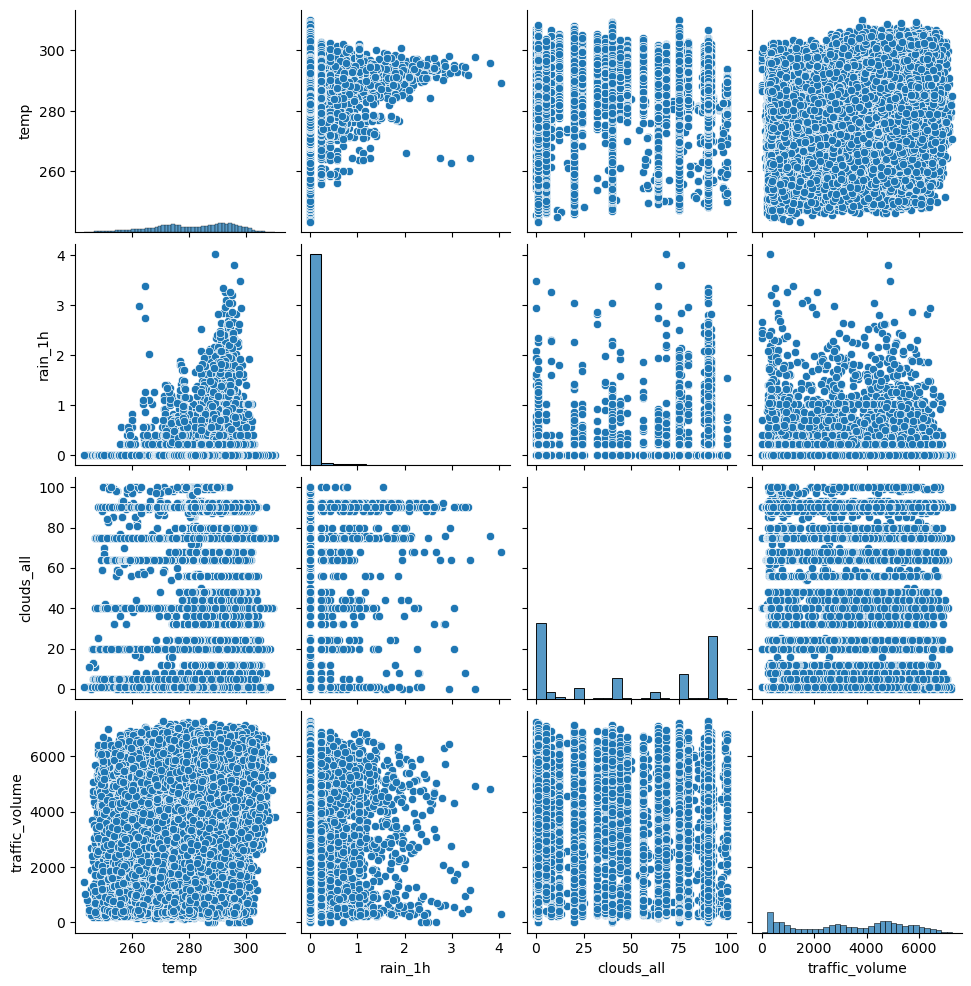

In [21]:
# Visualize the continuous numerical data
num_data = pp_data.iloc[:, n_enc_col:]
# num_data = enc_data.drop(columns=cat_cols + ['date_time', 'day_of_week', 'day_of_year', 'year']).iloc[:, n_enc_col:]
sns.pairplot(num_data);
plt.show()


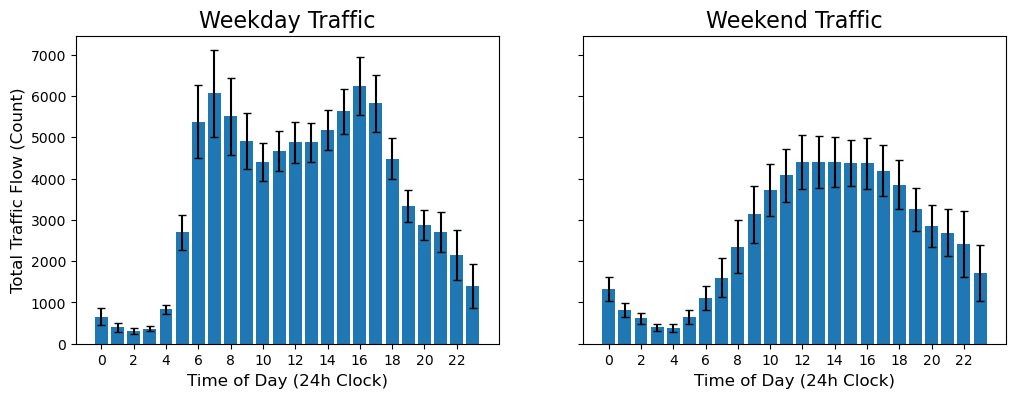

In [22]:
# Plot the traffic volume distribution by hour, and separated by weekday/weekend
h_len = len(clean_data.hour.unique())
weekday_data = holi_data.loc[holi_data.weekday == 1]
# display(weekday_data.head(n=5))
weekend_data = holi_data.loc[holi_data.weekday == 0]
hour_vol_data = [weekday_data, weekend_data]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
title_ls = ['Weekday', 'Weekend']
for j, tmp_data in enumerate(hour_vol_data):
    hour_vol_avg = np.zeros(h_len)
    hour_vol_std = np.zeros_like(hour_vol_avg)
    for i in range(h_len):
        hour_vol_avg[i] = tmp_data.loc[tmp_data.hour == i, 'traffic_volume'].mean()
        hour_vol_std[i] = tmp_data.loc[tmp_data.hour == i, 'traffic_volume'].std()

    axes[j].bar(np.arange(h_len), hour_vol_avg)
    axes[j].errorbar(np.arange(h_len), hour_vol_avg, hour_vol_std, color='k', capsize=3, ls='none')
    axes[j].set_xlabel('Time of Day (24h Clock)', fontsize=12)
    axes[j].set_title(f'{title_ls[j]} Traffic', fontsize=16)
    axes[j].set_xticks(np.arange(h_len)[::2])
axes[0].set_ylabel('Total Traffic Flow (Count)', fontsize=12)
plt.show()


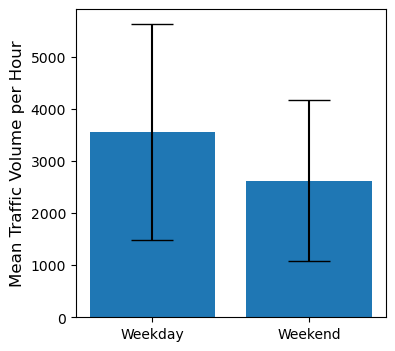

In [23]:
# Look at average traffic volume divided by weekday vs. weekend
weekday_end_vol_avg = np.zeros(2)
weekday_end_vol_std = np.zeros_like(weekday_end_vol_avg)
for i in range(weekday_end_vol_avg.size):
    weekday_end_vol_avg[i] = hour_vol_data[i].traffic_volume.mean()
    weekday_end_vol_std[i] = hour_vol_data[i].traffic_volume.std()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.bar(np.arange(2), weekday_end_vol_avg)
ax.errorbar(np.arange(2), weekday_end_vol_avg, weekday_end_vol_std, color='k', capsize=15, ls='none')
# ax.set_xlabel('Type of Weather', fontsize=12)
ax.set_ylabel('Mean Traffic Volume per Hour', fontsize=12)
ax.set_xticks(np.arange(2))
# ax.set_xticklabels(title_ls, rotation=45, ha='right')
ax.set_xticklabels(title_ls)
plt.show()


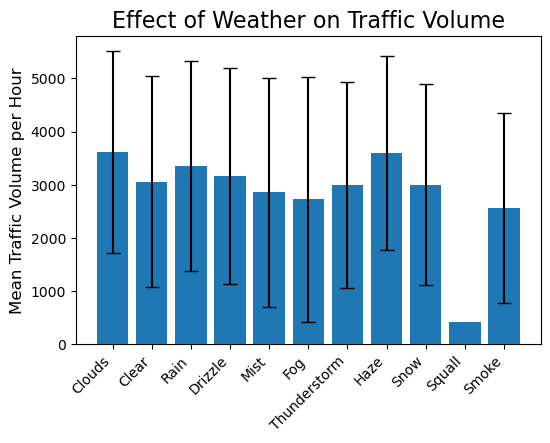

In [24]:
# Plot traffic flow as a function of weather
weather_types = list(clean_data.weather_main.unique())
# print(weather_types)
weather_vol_avg = np.zeros(len(weather_types))
weather_vol_std = np.zeros_like(weather_vol_avg)
for i, weather in enumerate(weather_types):
    # weather_inds = clean_data.loc[clean_data.weather_main == weather].index
    # n_instances = weather_inds.values.size
    # weather_vol[i] = clean_data.traffic_volume.iloc[weather_inds].sum() / n_instances
    # weather_vol[i] = clean_data.traffic_volume.iloc[weather_inds].mean()
    weather_vol_avg[i] = clean_data.loc[clean_data.weather_main == weather, 'traffic_volume'].mean()
    weather_vol_std[i] = clean_data.loc[clean_data.weather_main == weather, 'traffic_volume'].std()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.bar(np.arange(len(weather_types)), weather_vol_avg)
ax.errorbar(np.arange(len(weather_types)), weather_vol_avg, weather_vol_std, color='k', capsize=5, ls='none')
# ax.set_xlabel('Type of Weather', fontsize=12)
ax.set_title('Effect of Weather on Traffic Volume', fontsize=16)
ax.set_ylabel('Mean Traffic Volume per Hour', fontsize=12)
ax.set_xticks(np.arange(len(weather_types)))
ax.set_xticklabels(weather_types, rotation=45, ha='right')
plt.show()


## Machine Learning

- Split into train and test: try shuffled and unshuffled (leave out one year)
- Try whitening the numerical data (should I whiten it?). No use normalization since the underlying distributions are non-Gaussian. The tree methods are agnostic to this anyway.
- Future: try combining a RandomizedSearchCV to find general areas of parameters, then narrow down with GridSearchCV as done [here](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)


In [25]:
# Split into train and test sets
X_pd, y_pd = pp_data.iloc[:, :-1], pp_data.iloc[:, -1]

# Split the data by shuffling
tmp_split = train_test_split(X_pd, y_pd, test_size=0.215, random_state=66)
rand_split = [x.reset_index(drop=True) for x in tmp_split]
# display(rand_split[0].head(n=5))
# print(type(rand_split[0]))
print(len(rand_split[0]))

# Split the data by extracting a contiguous year for testing
train_inds = enc_data.loc[enc_data.year != 2017].index
test_inds = enc_data.loc[enc_data.year == 2017].index
X_train_year = X_pd.iloc[train_inds].reset_index(drop=True)
X_test_year = X_pd.iloc[test_inds].reset_index(drop=True)
y_train_year = y_pd.iloc[train_inds].reset_index(drop=True)
y_test_year = y_pd.iloc[test_inds].reset_index(drop=True)
print(len(X_train_year))

data_splits = [rand_split, [X_train_year, X_test_year, y_train_year, y_test_year]]


31851
31862


In [26]:
# Normalize the data using the numerical training features
norm_splits = []
X_scalers = []
y_scalers = []
for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
    # Extract the numerical data
    X_train_num = X_train.iloc[:, n_enc_col:]
    X_test_num = X_test.iloc[:, n_enc_col:]

    # Normalize the data
    X_scaler = MinMaxScaler()
    X_scaler = X_scaler.fit(X_train_num)
    X_scalers.append(X_scaler)
    X_train_num_norm = X_scaler.transform(X_train_num)
    X_test_num_norm = X_scaler.transform(X_test_num)
    y_scaler = MinMaxScaler()
    y_scaler = y_scaler.fit(y_train.values.reshape(-1, 1))
    y_scalers.append(y_scaler)
    y_train_norm = y_scaler.transform(y_train.values.reshape(-1, 1))
    y_test_norm = y_scaler.transform(y_test.values.reshape(-1, 1))
    
    # Convert normalized data to pd.DataFrames
    X_train_num_norm_pd = pd.DataFrame(X_train_num_norm)
    X_test_num_norm_pd = pd.DataFrame(X_test_num_norm)
    y_train_norm_pd = pd.Series(y_train_norm.squeeze())
    y_test_norm_pd = pd.Series(y_test_norm.squeeze())
    y_train_norm_pd.columns = pp_data.columns[-1:]
    y_test_norm_pd.columns = pp_data.columns[-1:]

    # Recombine with the categorical data
    X_train_norm = pd.concat((X_train.iloc[:, :n_enc_col], X_train_num_norm_pd), axis=1)
    X_test_norm = pd.concat((X_test.iloc[:, :n_enc_col], X_test_num_norm_pd), axis=1)
    X_train_norm.columns = pp_data.columns[:-1]
    X_test_norm.columns = pp_data.columns[:-1]
    # display(X_train_norm.head(n=5))

    # Append the normalized data
    norm_splits.append([X_train_norm, X_test_norm, y_train_norm_pd, y_test_norm_pd])


In [27]:
# # Load the models from a pickle file
# with open('models/trained_models.pkl', 'rb') as file:
#     models = pkl.load(file)
    

In [28]:
# Define a grid search to train and test the model
cv_splits = [ShuffleSplit(n_splits=10, test_size=0.2, random_state=66),
             TimeSeriesSplit(n_splits=5)]

# Random forest regressor
d_forest = {'name': 'Random Forest',
           'model': RandomForestRegressor(random_state=66),
           'n_itr': 200,
           'params': {'n_estimators': [50, 100, 200, 300, 500, 700, 1000],
                      'max_features': [1.0, 'sqrt'],
                      'max_depth': [2, 3, 4, 5, 6, 7, 8],
                      'min_samples_split': np.linspace(0.2, 0.9, 8),
                      'min_samples_leaf': [5, 10, 20, 30, 40, 50, 70, 100],
                      'max_leaf_nodes': [100, 80, 60, 40, 20, 10, 5],
                      'max_samples': np.linspace(0.1, 1., 10),
                      'ccp_alpha': np.linspace(0, 0.05, 11)}}

# SVR
d_svr = {'name': 'SVR',
         'model': SVR(kernel='rbf'),
         'n_itr': 10,
         'params': {'gamma': ['scale', 'auto'],
                    'C': [10, 50, 100],
                    'epsilon': [0.1, 0.2, 0.4, 0.6]}}

# XGBoost
d_xgb = {'name': 'XGBoost',
         'model': XGBRegressor(),
         'n_itr': 100,
         'params': {'n_estimators': [50, 100, 200, 300, 500, 700, 1000],
                    'learning_rate': np.linspace(0., 0.9, 10),
                    'subsample': np.linspace(0.1, 1., 10),
                    'min_child_weight': [0.1, 1, 5, 10, 20, 50],
                    'max_leaves': [5, 10, 20, 40, 70, 100],
                    'max_depth': np.arange(1, 12),
                    'gamma': [1, 2, 4, 7, 10, 15, 20, 25]}}

# Assign the models to a dictionary
models = {'forest': d_forest.copy(),
          'svr': d_svr.copy(),
          'xgb': d_xgb.copy()}
# models = {'forest': d_forest.copy(),
#           'xgb': d_xgb.copy()}


In [29]:
# Find the best models
t_start = time()
for model in models.values():
    print(model['name'])
    
    # Select a model using both shuffled and contiguous data
    split_search = []
    split_train_scores = []
    for X_train, X_test, y_train, y_test in data_splits:
        
        # Select a model using multiple cross-validation schemes
        cv_search = []
        cv_train_scores = []
        for cv_split in cv_splits:
            
            # Initialize a random parameter search
            n_itr = model['n_itr']
            param_search = RandomizedSearchCV(model['model'], model['params'], n_iter=n_itr, scoring='r2', n_jobs=-1, cv=cv_split)
        
            # Find the best model
            t_run0 = time()
            param_search.fit(X_train, y_train)
            t_run = time() - t_run0
            print(f'Took {timedelta(seconds=t_run)} to run the grid search')

            # # Display the top results and parameters
            # rand_results = pd.DataFrame(param_search.cv_results_)
            # rand_results = rand_results.sort_values(by=['rank_test_score'])
            # rand_results = rand_results[['params', 'mean_test_score', 'std_test_score']]
            # display(rand_results.head(n=10))
            
            # Save the cross-validation results
            cv_search.append(param_search)
            cv_train_scores.append(param_search.best_score_)

        # Save the data split results
        split_search.append(cv_search)
        split_train_scores.append(cv_train_scores)

    # Update the dictionary
    model['model_search'] = split_search
    model['best_train_r2'] = split_train_scores
    model['training_tree'] = [['Shuffled Data', 'Contiguous Data'],
                              ['Shuffle Split Cross-validation',
                               'Time Series Cross-validation']]
    print()

# Print the time taken
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to run all grid searches')


Random Forest
Took 0:05:46.498704 to run the grid search
Took 0:02:21.417827 to run the grid search
Took 0:05:35.057853 to run the grid search
Took 0:02:08.953816 to run the grid search

SVR
Took 0:19:33.188857 to run the grid search
Took 0:03:47.947949 to run the grid search
Took 0:13:12.146844 to run the grid search
Took 0:03:42.539943 to run the grid search

XGBoost
Took 0:18:10.565393 to run the grid search
Took 0:05:50.781957 to run the grid search
Took 0:16:09.825383 to run the grid search
Took 0:05:41.118435 to run the grid search

Took 1:42:00.045331 to run all grid searches


In [30]:
# Find the best models
t_start = time()
for model in models.values():
    print(model['name'])
    
    # Select a model using both shuffled and contiguous data
    split_search = []
    split_train_scores = []
    for X_train, X_test, y_train, y_test in norm_splits:
        
        # Select a model using multiple cross-validation schemes
        cv_search = []
        cv_train_scores = []
        for cv_split in cv_splits:
            
            # Initialize a random parameter search
            n_itr = model['n_itr']
            param_search = RandomizedSearchCV(model['model'], model['params'], n_iter=n_itr, scoring='r2', n_jobs=-1, cv=cv_split)
        
            # Find the best model
            t_run0 = time()
            param_search.fit(X_train, y_train)
            t_run = time() - t_run0
            print(f'Took {timedelta(seconds=t_run)} to run the grid search')

            # # Display the top results and parameters
            # rand_results = pd.DataFrame(param_search.cv_results_)
            # rand_results = rand_results.sort_values(by=['rank_test_score'])
            # rand_results = rand_results[['params', 'mean_test_score', 'std_test_score']]
            # display(rand_results.head(n=10))
            
            # Save the cross-validation results
            cv_search.append(param_search)
            cv_train_scores.append(param_search.best_score_)

        # Save the data split results
        split_search.append(cv_search)
        split_train_scores.append(cv_train_scores)

    # Update the dictionary
    model['model_search_norm'] = split_search
    model['best_train_r2_norm'] = split_train_scores
    print()

# Print the time taken
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to run all grid searches')


Random Forest
Took 0:03:50.266027 to run the grid search
Took 0:01:42.738072 to run the grid search
Took 0:04:25.974156 to run the grid search
Took 0:01:39.075523 to run the grid search

SVR
Took 0:05:43.749279 to run the grid search
Took 0:01:30.053810 to run the grid search
Took 0:06:39.865564 to run the grid search
Took 0:00:08.007304 to run the grid search

XGBoost
Took 0:19:14.368787 to run the grid search
Took 0:06:02.674069 to run the grid search
Took 0:15:52.969343 to run the grid search
Took 0:05:52.231439 to run the grid search

Took 1:12:41.975710 to run all grid searches


Random Forest
[[0.8131621260411454, 0.8159261086104784], [0.8243525829831857, 0.8238991659895969]]
[[0.8156733552901576, 0.794836822750785], [0.8009750658095205, 0.8241833679013018]]
SVR
[[0.5733895100435207, 0.6256148352586153], [0.6539578707563987, 0.6539561577201094]]
[[0.9368845258626242, 0.9363597133554401], [0.9365929568331902, 0.8846789503586702]]
XGBoost
[[0.9699889286719005, 0.970435583077867], [0.9504516202648204, 0.9566906211283888]]
[[0.9445818450015064, 0.9438888616038601], [0.9529727052612215, 0.9519995195058942]]


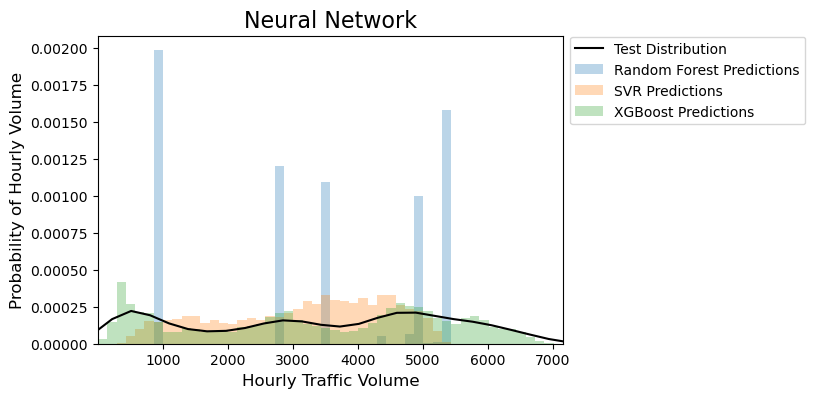

In [31]:
# Check the performance of the models on the test data
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for m, model in enumerate(models.values()):
    print(model['name'])
    model_searches = model['model_search']
    model_searches_norm = model['model_search_norm']
    split_test_scores = []
    split_norm_test_scores = []
    for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
        X_norm_train, X_norm_test, y_train_norm, y_test_norm = norm_splits[i]
        cv_test_scores = []
        cv_norm_test_scores = []
        for j in range(len(cv_splits)):
            # Model trained on unnormalized data
            best_model = model_searches[i][j].best_estimator_
            y_pred = best_model.predict(X_test)
            cv_test_scores.append(r2_score(y_test, y_pred))

            # Model trained on normalized data
            best_norm_model = model_searches_norm[i][j].best_estimator_
            y_pred_norm = best_norm_model.predict(X_norm_test)
            cv_norm_test_scores.append(r2_score(y_test_norm, y_pred_norm))
            
            # Plot the predicted distribution
            if (i == 0) and (j == 0):
                _, bins = np.histogram(y_test, bins=50)
                if m == 0:
                    y_test.plot.kde(ind=50, color='k', ax=ax, label='Test Distribution')
                y_pred = pd.Series(y_pred)
                ax.hist(y_pred, bins, color=f'C{m}', histtype='bar', density=True, alpha=0.3, label=model['name'] + ' Predictions')
                ax.set_title('Prediction Distributions', fontsize=16)
                ax.set_xlim([bins[0], bins[-1]])
                ax.set_ylabel('Probability of Hourly Volume', fontsize=12)
                ax.set_xlabel('Hourly Traffic Volume', fontsize=12)
        
        # Save the data split results
        split_test_scores.append(cv_test_scores)
        split_norm_test_scores.append(cv_norm_test_scores)

    # Update the dictionary
    model['best_test_r2'] = split_test_scores
    model['best_test_r2_norm'] = split_norm_test_scores
    print(split_test_scores)
    print(split_norm_test_scores)

ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
plt.show()


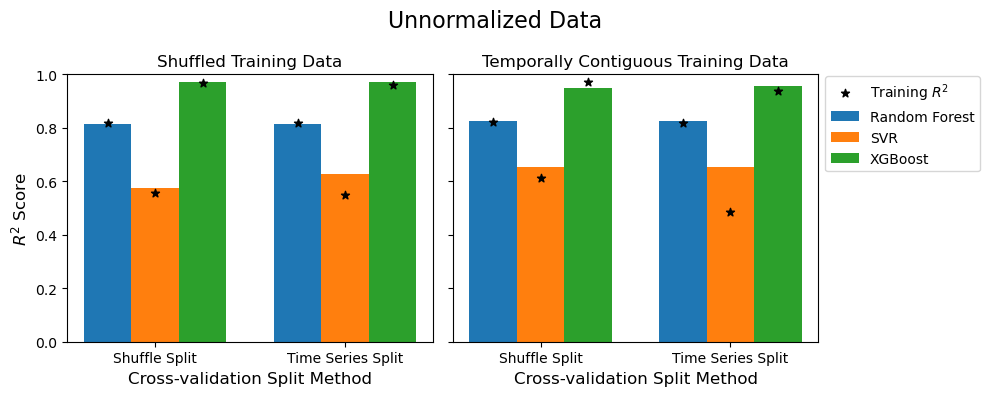

In [32]:
# Compare the models using shuffled and unshuffled data
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
width = 1 / (len(models) + 1)
plt_ttls = ['Shuffled Training Data', 'Temporally Contiguous Training Data']
for i, model in enumerate(models.values()):
    train_scores = model['best_train_r2']
    test_scores = model['best_test_r2']
    m_name = model['name']
    x_pos = np.arange(len(train_scores)) + i * width
    for j, train_score in enumerate(train_scores):
        axes[j].bar(x_pos, test_scores[j], width=width, label=m_name)
        if i == 2:
            axes[j].scatter(x_pos, train_score, c='k', marker='*', label='Training ' + r'$R^2$')
        else:
            axes[j].scatter(x_pos, train_score, c='k', marker='*')
        axes[j].set_xlabel('Cross-validation Split Method', fontsize=12)
        axes[j].set_title(plt_ttls[j], fontsize=12)
        axes[j].set_xticks(np.arange(len(train_scores)) + width)
        axes[j].set_xticklabels(['Shuffle Split', 'Time Series Split'])
        axes[j].set_ylim([0, 1])
axes[0].set_ylabel(r'$R^2$' + ' Score', fontsize=12)
axes[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
fig.suptitle('Unnormalized Data', fontsize=16)
fig.tight_layout()
plt.show()


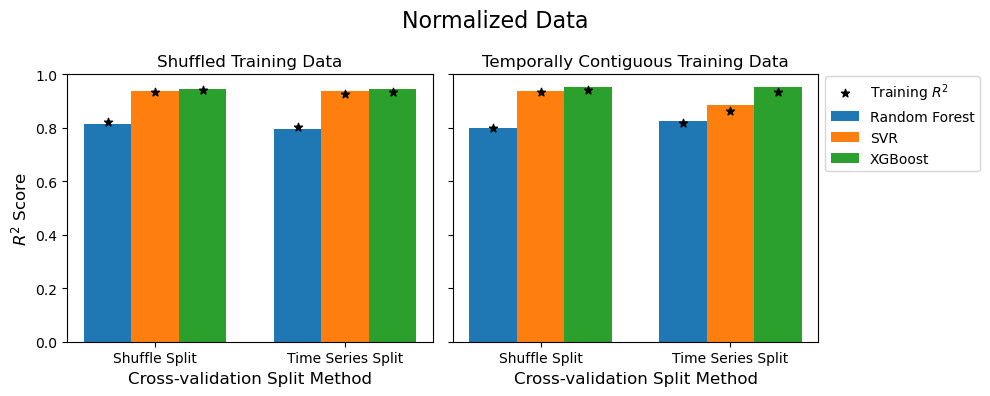

In [33]:
# Compare the models using whitened and unwhiteded data
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
width = 1 / (len(models) + 1)
plt_ttls = ['Shuffled Training Data', 'Temporally Contiguous Training Data']
for i, model in enumerate(models.values()):
    train_scores = model['best_train_r2_norm']
    test_scores = model['best_test_r2_norm']
    m_name = model['name']
    x_pos = np.arange(len(train_scores)) + i * width
    for j, train_score in enumerate(train_scores):
        axes[j].bar(x_pos, test_scores[j], width=width, label=m_name)
        if i == 2:
            axes[j].scatter(x_pos, train_score, c='k', marker='*', label='Training ' + r'$R^2$')
        else:
            axes[j].scatter(x_pos, train_score, c='k', marker='*')
        axes[j].set_xlabel('Cross-validation Split Method', fontsize=12)
        axes[j].set_title(plt_ttls[j], fontsize=12)
        axes[j].set_xticks(np.arange(len(train_scores)) + width)
        axes[j].set_xticklabels(['Shuffle Split', 'Time Series Split'])
        axes[j].set_ylim([0, 1])
axes[0].set_ylabel(r'$R^2$' + ' Score', fontsize=12)
axes[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
fig.suptitle('Normalized Data', fontsize=16)
fig.tight_layout()
plt.show()


## Model Improvement

- Refine parameter search
- Check effects of using categorical values with random forest regressor (since it can handle categorical features)
- Check effects of splitting data along identifiable features (eg. night/day) and training separate models for each
- Normalization vs. whitening? (Or may just do normalization from the beginning?)
- Dropping the rain_1h feature

In [34]:
# Check the effects of categories on the random forest regressor
cat_tree = d_forest.copy()
cat_tree['name'] = 'Random Forest Categories'

# Create a categorized dataset for the tree regressor
tree_data = holi_data.drop(columns=cat_cols + ['date_time', 'day_of_week', 'year'])
# tree_data = holi_data.drop(columns=cat_cols + ['date_time', 'day_of_week', 'year', 'rain_1h'])
tree_data['rain_1h'] = np.log(tree_data['rain_1h'] + 1)
tree_cols = tree_data.columns.tolist()
tree_cols = tree_cols[-2:] + tree_cols[:-2]
tree_data = tree_data[tree_cols]
# display(tree_data.head(n=5))

# Split the data into training and test sets
X_tree_pd = tree_data.iloc[:, :-1]
X_train_tree = X_tree_pd.iloc[train_inds].reset_index(drop=True)
X_test_tree = X_tree_pd.iloc[test_inds].reset_index(drop=True)
tree_split = train_test_split(X_tree_pd, y_pd, test_size=0.215, random_state=66)
rand_tree_split = [x.reset_index(drop=True) for x in tree_split]
data_splits_tree = [rand_tree_split, [X_train_tree, X_test_tree, y_train_year, y_test_year]]

# Select a model using both shuffled and contiguous data
split_search = []
split_train_scores = []
split_test_scores = []
t_start = time()
for X_train, X_test, y_train, y_test in data_splits_tree:
    # Select a model using multiple cross-validation schemes
    cv_search = []
    cv_train_scores = []
    cv_test_scores = []
    for cv_split in cv_splits:
        # Initialize a grid
        n_itr = cat_tree['n_itr']
        param_search = RandomizedSearchCV(cat_tree['model'], cat_tree['params'], n_iter=n_itr, scoring='r2', n_jobs=-1, cv=cv_split)

        # Find the best model
        t_run0 = time()
        param_search.fit(X_train, y_train)
        t_run = time() - t_run0
        print(f'Took {timedelta(seconds=t_run)} to run the grid search')

        # Save the results
        cv_search.append(param_search)
        cv_train_scores.append(param_search.best_score_)

        # Check the performance of the models on the test data
        best_model = param_search.best_estimator_
        y_pred = best_model.predict(X_test)
        cv_test_scores.append(r2_score(y_test, y_pred))
        print(param_search.best_params_)

    split_search.append(cv_search)
    split_train_scores.append(cv_train_scores)
    split_test_scores.append(cv_test_scores)

# Update the dictionary
cat_tree['model_search'] = split_search
cat_tree['best_train_r2'] = split_train_scores
cat_tree['best_test_r2'] = split_test_scores
cat_tree['training_tree'] = [['Shuffled Data', 'Contiguous Data'],
                            ['Shuffle Split Cross-validation',
                             'Time Series Cross-validation']]
print('Training scores: ', split_train_scores)
print('Testing scores: ', split_test_scores)

# Print the time taken
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to run all grid searches')

# Add model to the dictionary
models['cat_tree'] = cat_tree


Took 0:03:58.189611 to run the grid search
{'n_estimators': 100, 'min_samples_split': 0.2, 'min_samples_leaf': 40, 'max_samples': 0.9, 'max_leaf_nodes': 60, 'max_features': 1.0, 'max_depth': 8, 'ccp_alpha': 0.04}
Took 0:01:26.073404 to run the grid search
{'n_estimators': 200, 'min_samples_split': 0.2, 'min_samples_leaf': 20, 'max_samples': 1.0, 'max_leaf_nodes': 10, 'max_features': 1.0, 'max_depth': 6, 'ccp_alpha': 0.01}
Took 0:03:58.965226 to run the grid search
{'n_estimators': 1000, 'min_samples_split': 0.2, 'min_samples_leaf': 5, 'max_samples': 1.0, 'max_leaf_nodes': 20, 'max_features': 1.0, 'max_depth': 6, 'ccp_alpha': 0.05}
Took 0:01:31.266986 to run the grid search
{'n_estimators': 700, 'min_samples_split': 0.2, 'min_samples_leaf': 10, 'max_samples': 0.9, 'max_leaf_nodes': 20, 'max_features': 1.0, 'max_depth': 6, 'ccp_alpha': 0.01}
Training scores:  [[0.8117962257841136, 0.8092570340772267], [0.8078778253064364, 0.8065042722546275]]
Testing scores:  [[0.8052663578835578, 0.8052

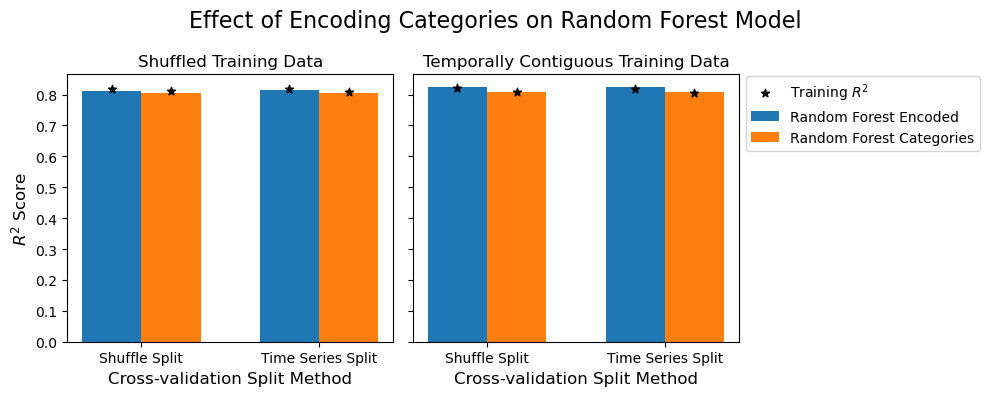

In [35]:
# Compare the models using shuffled and unshuffled data
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
width = 1 / 3
plt_ttls = ['Shuffled Training Data', 'Temporally Contiguous Training Data']
bar_names = ['Random Forest Encoded', 'Random Forest Categories']
cnt = 0
for key, model in models.items():
    if key in ['forest', 'cat_tree']:
        train_scores = model['best_train_r2']
        test_scores = model['best_test_r2']
        x_pos = np.arange(len(train_scores)) + cnt * width
        for j, train_score in enumerate(train_scores):
            axes[j].bar(x_pos, test_scores[j], width=width, label=bar_names[cnt])
            if cnt == 0:
                axes[j].scatter(x_pos, train_score, c='k', marker='*', label='Training ' + r'$R^2$')
            else:
                axes[j].scatter(x_pos, train_score, c='k', marker='*')
            axes[j].set_xlabel('Cross-validation Split Method', fontsize=12)
            axes[j].set_title(plt_ttls[j], fontsize=12)
            axes[j].set_xticks(np.arange(len(train_scores)) + width / 2)
            axes[j].set_xticklabels(['Shuffle Split', 'Time Series Split'])
        cnt += 1
axes[0].set_ylabel(r'$R^2$' + ' Score', fontsize=12)
axes[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
fig.suptitle('Effect of Encoding Categories on Random Forest Model', fontsize=16)
fig.tight_layout()
plt.show()


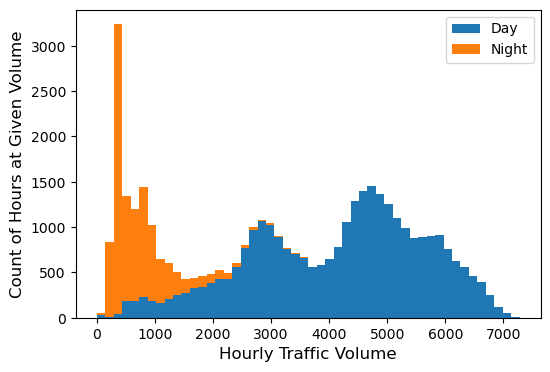

In [36]:
# Find bimodality in traffic volume
day_mask = (enc_data.hour > 4) & (enc_data.hour < 23)
day_vols = enc_data.traffic_volume.loc[day_mask]
night_vols = enc_data.traffic_volume.loc[~day_mask]
day_counts, bins = np.histogram(day_vols, bins=50)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist([day_vols, night_vols], bins, histtype='bar', stacked=True, label=['Day', 'Night'])
ax.set_ylabel('Count of Hours at Given Volume', fontsize=12)
ax.set_xlabel('Hourly Traffic Volume', fontsize=12)
ax.legend()
plt.show()


In [37]:
# Separate the day and night data to improve model
day_data = pp_data.loc[day_mask]
night_data = pp_data.loc[~day_mask]

# Split into training and test sets
X_day_pd, y_day_pd = day_data.iloc[:, :-1], day_data.iloc[:, -1]
X_night_pd, y_night_pd = night_data.iloc[:, :-1], night_data.iloc[:, -1]

# Split the data by shuffling
tmp_split = train_test_split(X_day_pd, y_day_pd, test_size=0.2, random_state=66)
day_split = [x.reset_index(drop=True) for x in tmp_split]
tmp_split = train_test_split(X_night_pd, y_night_pd, test_size=0.2, random_state=66)
night_split = [x.reset_index(drop=True) for x in tmp_split]
day_night_data = [day_split, night_split]

# Normalize the data using the numerical training features
# day_night_norm = []
day_night_X_scalers = []
day_night_y_scalers = []
for i, (X_train, X_test, y_train, y_test) in enumerate(day_night_data):
    # Extract the numerical data
    X_train_num = X_train.iloc[:, n_enc_col:]
    X_test_num = X_test.iloc[:, n_enc_col:]

    # Normalize the data
    X_scaler = MinMaxScaler()
    X_scaler = X_scaler.fit(X_train_num)
    day_night_X_scalers.append(X_scaler)
    X_train_num_norm = X_scaler.transform(X_train_num)
    X_test_num_norm = X_scaler.transform(X_test_num)
    y_scaler = MinMaxScaler()
    y_scaler = y_scaler.fit(y_train.values.reshape(-1, 1))
    day_night_y_scalers.append(y_scaler)
    y_train_norm = y_scaler.transform(y_train.values.reshape(-1, 1))
    y_test_norm = y_scaler.transform(y_test.values.reshape(-1, 1))

    # Convert normalized data to pd.DataFrames
    X_train_num_norm_pd = pd.DataFrame(X_train_num_norm)
    X_test_num_norm_pd = pd.DataFrame(X_test_num_norm)
    y_train_norm_pd = pd.Series(y_train_norm.squeeze())
    y_test_norm_pd = pd.Series(y_test_norm.squeeze())
    y_train_norm_pd.columns = pp_data.columns[-1:]
    y_test_norm_pd.columns = pp_data.columns[-1:]

    # Recombine with the categorical data
    X_train_norm = pd.concat((X_train.iloc[:, :n_enc_col], X_train_num_norm_pd), axis=1)
    X_test_norm = pd.concat((X_test.iloc[:, :n_enc_col], X_test_num_norm_pd), axis=1)
    X_train_norm.columns = pp_data.columns[:-1]
    X_test_norm.columns = pp_data.columns[:-1]

    # Append the normalized data
    # day_night_norm.append([X_train_norm, X_test_norm, y_train_norm_pd, y_test_norm_pd])
    day_night_data[i] = [X_train_norm, X_test_norm, y_train_norm_pd, y_test_norm_pd]


In [38]:
# Fit the day and night models using a grid search
day_night_models = []
day_night_names = ['Day', 'Night']
day_night_test_pred = []
day_night_test_yt = []
t_start = time()
for i, (X_train, X_test, y_train, y_test) in enumerate(day_night_data):
    # Initialize a model and grid search
    print(f'{day_night_names[i]} Model')
    model = d_xgb.copy()
    cv_split = cv_splits[0]
    n_itr = model['n_itr']
    param_search = RandomizedSearchCV(model['model'], model['params'], n_iter=n_itr, scoring='r2', n_jobs=-1, cv=cv_split)

    # Find the best model
    t_run0 = time()
    param_search.fit(X_train, y_train)
    t_run = time() - t_run0
    print(f'Took {timedelta(seconds=t_run)} to run the grid search')

    # Save the results
    model['name'] = f'XGBoost {day_night_names[i]}'
    model['model_search'] = param_search
    model['best_train_r2'] = param_search.best_score_
    print(param_search.best_params_)
    
    # Calculate the performance
    y_pred = param_search.best_estimator_.predict(X_test)
    model['best_test_r2'] = r2_score(y_test, y_pred)
    day_night_models.append(model)

    # Calculate a combined y_pred to find the combined R2
    day_night_test_pred.append(y_pred)
    day_night_test_yt.append(y_test)
    
    # Add model to the dictionary
    models[f'{day_night_names[i]}_xgb'] = model
    
# Combined day and night R2 score
day_night_test_r2 = r2_score(np.hstack(day_night_test_yt), np.hstack(day_night_test_pred))

# Print the time taken
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to run all grid searches')


Day Model
Took 0:12:04.373650 to run the grid search
{'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 0.1, 'max_leaves': 5, 'max_depth': 9, 'learning_rate': 0.30000000000000004, 'gamma': 1}
Night Model
Took 0:04:54.691633 to run the grid search
{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 5, 'max_leaves': 10, 'max_depth': 5, 'learning_rate': 0.8, 'gamma': 1}
Took 0:16:59.073047 to run all grid searches


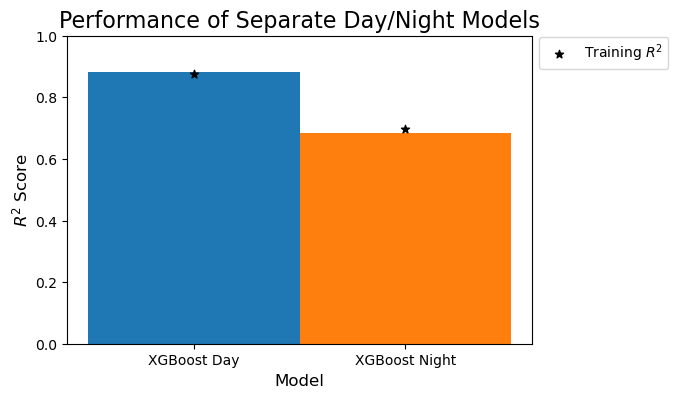

In [39]:
# Compare the day and night models
fig, ax = plt.subplots(1, figsize=(6, 4), sharey=True)
width = 1 / 3
m_names = []
for i, model in enumerate(day_night_models):
    train_score = model['best_train_r2']
    test_score = model['best_test_r2']
    m_name = model['name']
    m_names.append(model['name'])
    x_pos = i * width
    ax.bar(x_pos, test_score, width=width)
    if i == 1:
        ax.scatter(x_pos, train_score, c='k', marker='*', label='Training ' + r'$R^2$')
    else:
        ax.scatter(x_pos, train_score, c='k', marker='*')
ax.set_xlabel('Model', fontsize=12)
ax.set_title('Performance of Separate Day/Night Models', fontsize=16)
ax.set_xticks([0, width])
ax.set_xticklabels(m_names)
ax.set_ylabel(r'$R^2$' + ' Score', fontsize=12)
ax.set_ylim([0, 1])
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
plt.show()


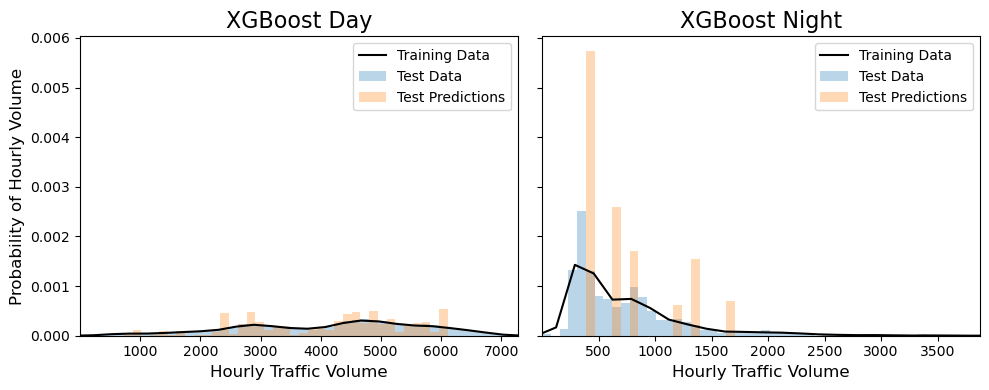

In [40]:
# Plot the distributions of the day and night test data and results
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, (X_train, X_test, y_train, y_test) in enumerate(day_night_data):
    y_scaler = day_night_y_scalers[i]
    model = day_night_models[i]
    best_model = model['model_search'].best_estimator_
    y_pred = y_scaler.inverse_transform(best_model.predict(X_test).reshape(-1, 1))
    y_train = pd.Series(y_scaler.inverse_transform(y_train.values.reshape(-1, 1)).squeeze())
    y_test = pd.Series(y_scaler.inverse_transform(y_test.values.reshape(-1, 1)).squeeze())
    _, bins = np.histogram(y_test, bins=50)
    y_train.plot.kde(ind=50, color='k', ax=axes[i], label='Training Data')
    # axes[i].hist(y_train, bins, histtype=u'step', color='k', density=True, label='Training Data')
    axes[i].hist(y_test, bins, histtype='bar', density=True, alpha=0.3, label='Test Data')
    axes[i].hist(y_pred, bins, histtype='bar', density=True, alpha=0.3, label='Test Predictions')
    axes[i].set_title(model['name'], fontsize=16)
    axes[i].set_xlim([bins[0], bins[-1]])
    axes[i].legend()
    # y_test.plot.kde(ind=50, color='C0', ax=axes[i])
    axes[i].set_xlabel('Hourly Traffic Volume', fontsize=12)
axes[0].set_ylabel('Probability of Hourly Volume', fontsize=12)
fig.tight_layout()
plt.show()


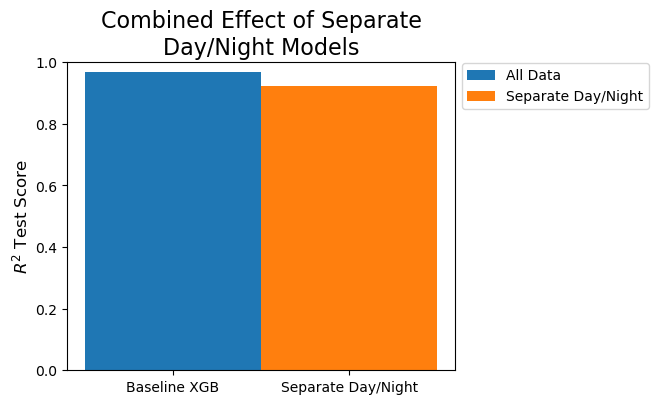

In [41]:
# Compare the day+night model performance to the baseline
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
width = 1 / 3
for i, model in enumerate(models.values()):
    if model['name'] == 'XGBoost':
        test_scores = model['best_test_r2']
        ax.bar(0, test_scores[0][0], width=width, label='All Data')
ax.bar(width, day_night_test_r2, width=width, label='Separate Day/Night')
# ax.set_xlabel('Cross-validation Split Method', fontsize=12)
ax.set_xticks([0, width])
ax.set_xticklabels(['Baseline XGB', 'Separate Day/Night'])
ax.set_title('Combined Effect of Separate\nDay/Night Models', fontsize=16)
ax.set_ylabel(r'$R^2$' + ' Test Score', fontsize=12)
ax.set_ylim([0, 1])
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
plt.show()


In [42]:
# Look at regression models and see if I can calculate the variance explained by day/night boolean
# Is this just the regression coefficient?

# Look at effect of removing rain_1h using adjusted R2

In [43]:
# Save the models in a pickle file
with open('models/trained_models.pkl', 'wb') as file:
    pkl.dump(models, file)


## Conclusions and Lessons Learned

- SVM methods don't scale well (long training and prediction times)
- Whitening the data ruined the SVR and reduced XGBoost performance (data shouldn't be whitened because it is not Gaussian)
- Encoding gives small improvement to the model
- Trees are agnostic to underlying distributions, so splitting data between day and night has no impact on performance
- Could use Guassian mixture modelling or Kernel Density Estimation
- Turns out that deep learning isn't that great for this kind of problem
- Model could be further improved with hyperparameter tuning using a grid search 

To Do
- Get rid of printing parameters after training. Print parameters later and look for similarities among best models. Comment on this. 
- Look at how large the saved models pickle file is. If it is too large to host on github, remove the trained model to see if that reduces the file size. All that's really necessary is the cv_report_. Everything else can be run again later.
- Split the notebook into different parts:
    1. EDA and data preprocessing (save data as .csv to be uploaded later)
    2. Model training and saving (save models with and without best trained version)
    3. Model analysis (add part looking at the best parameter combinations and choosing one based on that). Note: there are practices for how to choose a model (link to sklearn's documentation on this).


## Deep Learning

Try a neural network to see if I can get improved performance


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [45]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.length = X.shape[0]

    def __len__(self):
        return self.labels.size

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]
    
    def __len__(self):
        return self.length


    
# Define the model class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batch_loss = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y.squeeze())
        batch_loss.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    return batch_loss



In [46]:
# Define hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 500
loss_fn = nn.MSELoss()


In [47]:
# Define the training and test data loaders
split_ind = 0
X_train_nn, X_test_nn, y_train_nn, y_test_nn = [x.values for x in norm_splits[split_ind]]
train_data = CustomDataset(X_train_nn, y_train_nn)
test_data = CustomDataset(X_test_nn, y_test_nn)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize a model and optimizer
neural_net = NeuralNetwork(X_train.shape[-1], 32, 1).to('cpu')
neural_net = neural_net.float()
optimizer = torch.optim.SGD(neural_net.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(neural_net.parameters(), lr=learning_rate)


Took 0:02:50.845854 to train the model


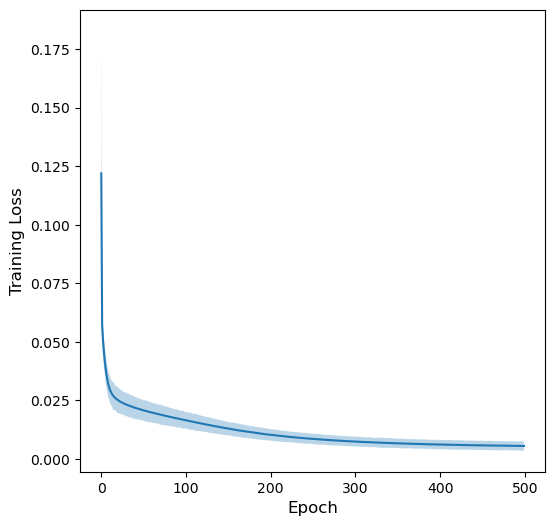

In [48]:
# Train the model
train_loss_avg = np.zeros(epochs)
train_loss_std = np.zeros(epochs)
t_start = time()
for t in range(epochs):
    epoch_loss = train_loop(train_dataloader, neural_net, loss_fn, optimizer)
    train_loss_avg[t] = np.mean(epoch_loss)
    train_loss_std[t] = np.std(epoch_loss)

# Plot the progression of loss and accuracy
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(np.arange(epochs), train_loss_avg)
ax.fill_between(np.arange(epochs), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)

# Print the time taken
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the model')
plt.show()


In [49]:
# Print the results
y_train_nn_pred = neural_net(torch.Tensor(X_train_nn)).detach().numpy()
y_test_nn_pred = neural_net(torch.Tensor(X_test_nn)).detach().numpy()
print(f'Training RMSE on NN model: {mean_squared_error(y_train_nn, y_train_nn_pred, squared=False):4.3f}')
print(f'Test RMSE on NN model: {mean_squared_error(y_test_nn, y_test_nn_pred, squared=False):4.3f}')
print(f'Test R^2 on NN model: {r2_score(y_test_nn, y_test_nn_pred):4.3f}')


Training RMSE on NN model: 0.075
Test RMSE on NN model: 0.076
Test R^2 on NN model: 0.923


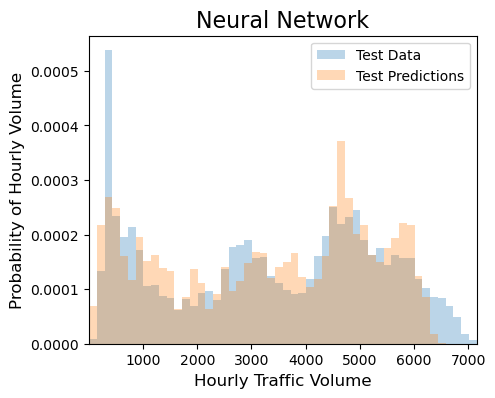

In [50]:
# Plot the distributions of the day and night test data and results
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
y_scaler = y_scalers[split_ind]
y_pred_hist = y_scaler.inverse_transform(y_train_nn_pred)
y_train_hist = pd.Series(y_scaler.inverse_transform(y_train_nn.reshape(-1, 1)).squeeze())
y_test_hist = pd.Series(y_scaler.inverse_transform(y_test_nn.reshape(-1, 1)).squeeze())
_, bins = np.histogram(y_test_hist, bins=50)
# ax.hist(y_train_hist, bins, histtype=u'step', color='k', density=True, label='Training Data')
ax.hist(y_test_hist, bins, histtype='bar', density=True, alpha=0.3, label='Test Data')
ax.hist(y_pred_hist, bins, histtype='bar', density=True, alpha=0.3, label='Test Predictions')
ax.set_title('Neural Network', fontsize=16)
ax.set_xlim([bins[0], bins[-1]])
ax.legend()
# y_test_hist.plot.kde(ind=50, color='C0', ax=ax)
ax.set_ylabel('Probability of Hourly Volume', fontsize=12)
ax.set_xlabel('Hourly Traffic Volume', fontsize=12)
plt.show()


### Separate Day and Night Models

In [51]:
# Define the training and test data loaders
day_night_arrays = []
day_night_loaders = []
day_night_nets = []
day_night_opti = []
for i, dn_data in enumerate(day_night_data):
    all_arrays = [x.values for x in dn_data]
    X_train_nn, X_test_nn, y_train_nn, y_test_nn = all_arrays
    day_night_arrays.append(all_arrays)
    train_data = CustomDataset(X_train_nn, y_train_nn)
    test_data = CustomDataset(X_test_nn, y_test_nn)
    dn_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dn_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    day_night_loaders.append((dn_train_dataloader, dn_test_dataloader))

    # Initialize a model and optimizer
    net = NeuralNetwork(X_train_nn.shape[-1], 32, 1).to('cpu')
    net = net.float()
    day_night_nets.append(net)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    # optimizer = torch.optim.Adam(neural_net.parameters(), lr=learning_rate)
    day_night_opti.append(optimizer)


Day Model
Took 0:02:12.775735 to train the model
Training RMSE on NN model: 0.089
Test RMSE on NN model: 0.088
Test R^2 on NN model: 0.812

Night Model
Took 0:00:44.924410 to train the model
Training RMSE on NN model: 0.092
Test RMSE on NN model: 0.095
Test R^2 on NN model: 0.414



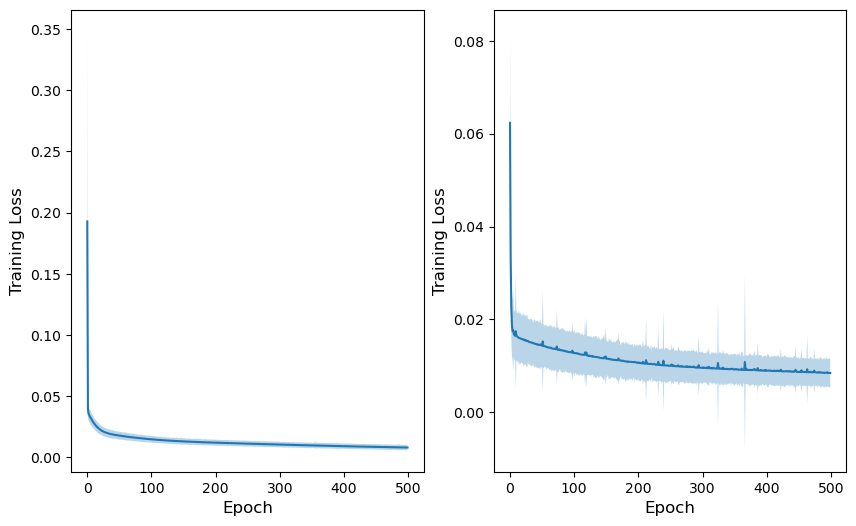

In [52]:
# Train the day/night models
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
for i, (train_loader, test_loader) in enumerate(day_night_loaders):
    print(f'{day_night_names[i]} Model')
    train_loss_avg = np.zeros(epochs)
    train_loss_std = np.zeros(epochs)
    t_start = time()
    for t in range(epochs):
        epoch_loss = train_loop(train_loader, day_night_nets[i], loss_fn, day_night_opti[i])
        train_loss_avg[t] = np.mean(epoch_loss)
        train_loss_std[t] = np.std(epoch_loss)

    # Plot the progression of loss and accuracy
    axes[i].plot(np.arange(epochs), train_loss_avg)
    axes[i].fill_between(np.arange(epochs), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
    axes[i].set_xlabel('Epoch', fontsize=12)
    axes[i].set_ylabel('Training Loss', fontsize=12)

    # Print the time taken
    t_full = time() - t_start
    print(f'Took {timedelta(seconds=t_full)} to train the model')

    # Print the results
    X_train_nn, X_test_nn, y_train_nn, y_test_nn = day_night_arrays[i]
    y_train_nn_pred = day_night_nets[i](torch.Tensor(X_train_nn)).detach().numpy()
    y_test_nn_pred = day_night_nets[i](torch.Tensor(X_test_nn)).detach().numpy()
    print(f'Training RMSE on NN model: {mean_squared_error(y_train_nn, y_train_nn_pred, squared=False):4.3f}')
    print(f'Test RMSE on NN model: {mean_squared_error(y_test_nn, y_test_nn_pred, squared=False):4.3f}')
    print(f'Test R^2 on NN model: {r2_score(y_test_nn, y_test_nn_pred):4.3f}')
    print()

plt.show()


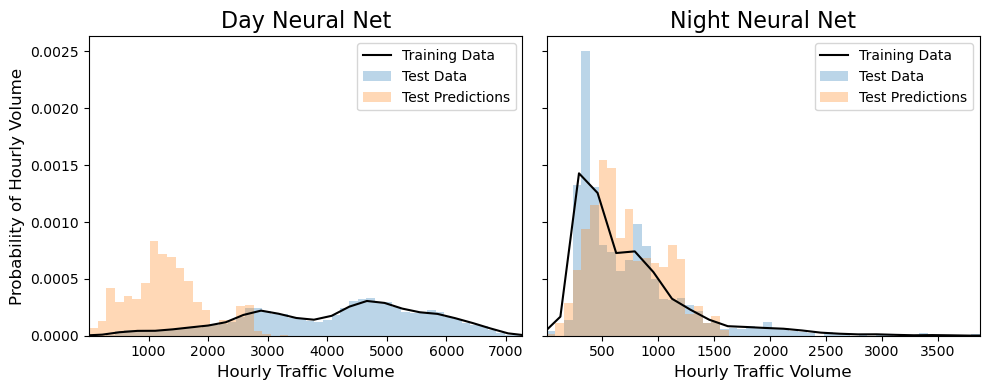

In [53]:
# Plot the distributions of the day and night test data and results
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, (X_train, X_test, y_train, y_test) in enumerate(day_night_data):
    y_scaler = day_night_y_scalers[i]
    nn_model = day_night_nets[i]
    y_pred = y_scaler.inverse_transform(day_night_nets[i](torch.Tensor(X_test_nn)).detach().numpy().reshape(-1, 1))
    y_train = pd.Series(y_scaler.inverse_transform(y_train.values.reshape(-1, 1)).squeeze())
    y_test = pd.Series(y_scaler.inverse_transform(y_test.values.reshape(-1, 1)).squeeze())
    _, bins = np.histogram(y_test, bins=50)
    y_train.plot.kde(ind=50, color='k', ax=axes[i], label='Training Data')
    # axes[i].hist(y_train, bins, histtype=u'step', color='k', density=True, label='Training Data')
    axes[i].hist(y_test, bins, histtype='bar', density=True, alpha=0.3, label='Test Data')
    axes[i].hist(y_pred, bins, histtype='bar', density=True, alpha=0.3, label='Test Predictions')
    axes[i].set_title(f'{day_night_names[i]} Neural Net', fontsize=16)
    axes[i].set_xlim([bins[0], bins[-1]])
    axes[i].legend()
    # y_test.plot.kde(ind=50, color='C0', ax=axes[i])
    axes[i].set_xlabel('Hourly Traffic Volume', fontsize=12)
axes[0].set_ylabel('Probability of Hourly Volume', fontsize=12)
fig.tight_layout()
plt.show()
